In [1]:
# ===================================================================
#           SETUP PEMODELAN v2.0
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Import semua model dan metrik yang kita butuhkan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Muat data yang sudah diproses dengan benar (dari notebook 01b)
df_final = pd.read_csv('../data/bank_additional_cleaned_1B.csv')

print("Data bersih v2 berhasil dimuat. Bentuk data:", df_final.shape)

# Pisahkan fitur (X) dan target (y)
X = df_final.drop('y', axis=1)
y = df_final['y']

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData berhasil dibagi menjadi training dan testing set.")
print("Bentuk X_train:", X_train.shape)
print("Bentuk X_test:", X_test.shape)

Data bersih v2 berhasil dimuat. Bentuk data: (41188, 47)

Data berhasil dibagi menjadi training dan testing set.
Bentuk X_train: (32950, 46)
Bentuk X_test: (8238, 46)


In [2]:
# ===================================================================
#           MELATIH ULANG 3 MODEL DASAR
# ===================================================================

# Hitung scale_pos_weight untuk XGBoost (dan class_weight untuk lainnya)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 1. Logistic Regression
model_lr_v2 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_lr_v2.fit(X_train, y_train)
y_pred_lr_v2 = model_lr_v2.predict(X_test)
print("\n--- Hasil Evaluasi Logistic Regression v2 ---")
print(classification_report(y_test, y_pred_lr_v2))

# 2. Random Forest
model_rf_v2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
model_rf_v2.fit(X_train, y_train)
y_pred_rf_v2 = model_rf_v2.predict(X_test)
print("\n--- Hasil Evaluasi Random Forest v2 ---")
print(classification_report(y_test, y_pred_rf_v2))

# 3. XGBoost (Default)
model_xgb_v2 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_v2.fit(X_train, y_train)
y_pred_xgb_v2 = model_xgb_v2.predict(X_test)
print("\n--- Hasil Evaluasi XGBoost (Default) v2 ---")
print(classification_report(y_test, y_pred_xgb_v2))

d:\ASAH\ML-LeadScoringPrediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Hasil Evaluasi Logistic Regression v2 ---
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.36      0.65      0.46       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238


--- Hasil Evaluasi Random Forest v2 ---
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.55      0.28      0.37       928

    accuracy                           0.89      8238
   macro avg       0.73      0.63      0.66      8238
weighted avg       0.87      0.89      0.88      8238



d:\ASAH\ML-LeadScoringPrediction\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



--- Hasil Evaluasi XGBoost (Default) v2 ---
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      7310
           1       0.38      0.60      0.47       928

    accuracy                           0.85      8238
   macro avg       0.66      0.74      0.69      8238
weighted avg       0.88      0.85      0.86      8238



In [3]:
# ===================================================================
#           HYPERPARAMETER TUNING v2
# ===================================================================
print("\nMemulai proses Hyperparameter Tuning untuk model v2...")

param_grid_v2 = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1, 0.2]
}

xgb_base_v2 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_v2 = GridSearchCV(estimator=xgb_base_v2, param_grid=param_grid_v2, scoring='f1', cv=3, verbose=2, n_jobs=-1)
grid_search_v2.fit(X_train, y_train)

print("\nProses Tuning Selesai!")
print("Parameter terbaik yang ditemukan:", grid_search_v2.best_params_)

best_xgb_tuned_v2 = grid_search_v2.best_estimator_
y_pred_best_xgb_v2 = best_xgb_tuned_v2.predict(X_test)

print("\n--- Hasil Evaluasi XGBoost (Tuned) v2 ---")
print(classification_report(y_test, y_pred_best_xgb_v2))


Memulai proses Hyperparameter Tuning untuk model v2...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


d:\ASAH\ML-LeadScoringPrediction\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Proses Tuning Selesai!
Parameter terbaik yang ditemukan: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}

--- Hasil Evaluasi XGBoost (Tuned) v2 ---
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      7310
           1       0.41      0.65      0.50       928

    accuracy                           0.85      8238
   macro avg       0.68      0.76      0.71      8238
weighted avg       0.89      0.85      0.87      8238



d:\ASAH\ML-LeadScoringPrediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Membuat analisis SHAP pada model final (bebas data leakage)...

Menampilkan Global Feature Importance (SHAP Summary Plot)...


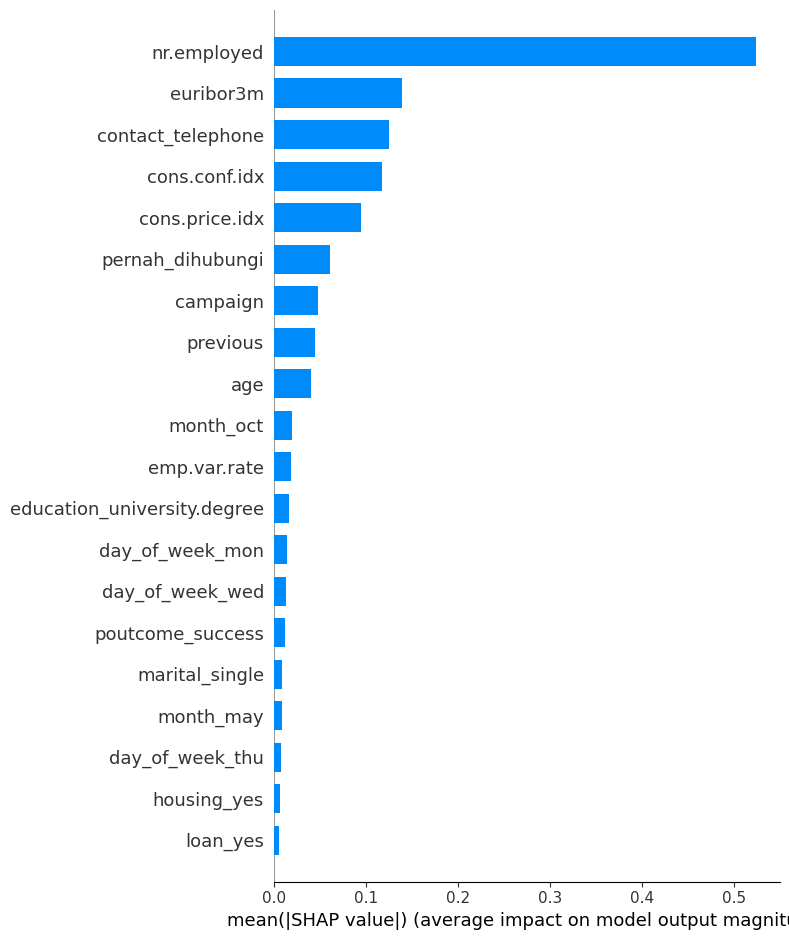


Menampilkan Dampak Detail Setiap Fitur...


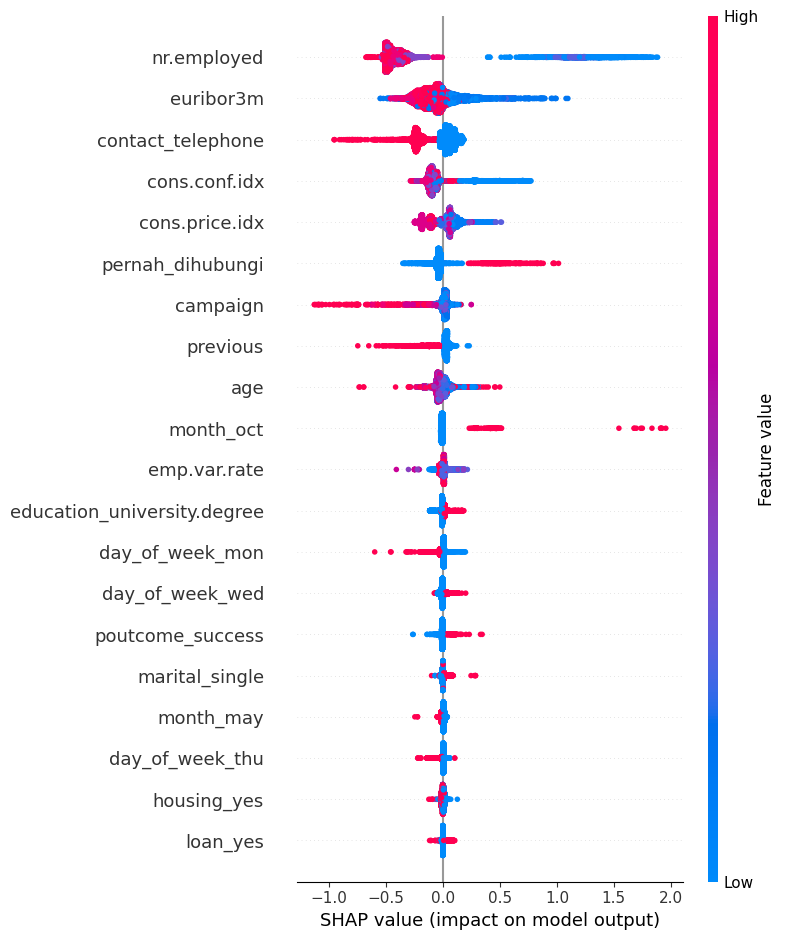

In [4]:
# ===================================================================
#           ANALISIS SHAP PADA MODEL FINAL v2
# ===================================================================
import shap

# Pastikan versi XGBoost Anda sudah 1.7.6
print("\nMembuat analisis SHAP pada model final (bebas data leakage)...")

explainer_v2 = shap.TreeExplainer(best_xgb_tuned_v2)
shap_values_v2 = explainer_v2.shap_values(X_test)

# Visualisasi Global Feature Importance
print("\nMenampilkan Global Feature Importance (SHAP Summary Plot)...")
shap.summary_plot(shap_values_v2, X_test, plot_type="bar")

# Visualisasi Dampak Detail Setiap Fitur
print("\nMenampilkan Dampak Detail Setiap Fitur...")
shap.summary_plot(shap_values_v2, X_test)

In [5]:
# ===================================================================
#           SIMPAN SEMUA MODEL v2
# ===================================================================

model_directory_v2 = '../models/models_V2' # Simpan di folder baru agar tidak tercampur
os.makedirs(model_directory_v2, exist_ok=True)

# Simpan semua model
models_to_save = {
    'logistic_regression_v2.pkl': model_lr_v2,
    'random_forest_v2.pkl': model_rf_v2,
    'xgboost_default_v2.pkl': model_xgb_v2,
    'xgboost_tuned_v2.pkl': best_xgb_tuned_v2
}

for filename, model in models_to_save.items():
    path = os.path.join(model_directory_v2, filename)
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model '{filename}' berhasil disimpan.")

Model 'logistic_regression_v2.pkl' berhasil disimpan.
Model 'random_forest_v2.pkl' berhasil disimpan.
Model 'xgboost_default_v2.pkl' berhasil disimpan.
Model 'xgboost_tuned_v2.pkl' berhasil disimpan.


In [6]:
# ===================================================================
#           RINGKASAN EVALUASI FINAL SEMUA MODEL v2
# ===================================================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("="*60)
print("   RINGKASAN KINERJA FINAL - MODEL v2 (BEBAS DATA LEAKAGE)")
print("="*60)

# Kumpulkan semua prediksi dalam satu dictionary agar mudah di-loop
all_predictions_v2 = {
    "Logistic Regression": y_pred_lr_v2,
    "Random Forest": y_pred_rf_v2,
    "XGBoost (Default)": y_pred_xgb_v2,
    "XGBoost (Tuned)": y_pred_best_xgb_v2
}

# Buat DataFrame untuk menyimpan hasil agar rapi
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision (Yes)', 'Recall (Yes)', 'F1-Score (Yes)'])

# Loop melalui setiap model dan hitung metriknya
for model_name, y_pred in all_predictions_v2.items():
    accuracy = accuracy_score(y_test, y_pred)
    # Gunakan pos_label=1 untuk memastikan kita menghitung metrik untuk kelas positif ('Yes')
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Tambahkan hasil ke DataFrame
    results_df.loc[len(results_df)] = [model_name, accuracy, precision, recall, f1]

# Tampilkan tabel ringkasan yang sudah diformat
print("\nTabel Perbandingan Kinerja Model v2:\n")

# Format angka agar lebih mudah dibaca
formatted_df = results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision (Yes)': '{:.4f}',
    'Recall (Yes)': '{:.4f}',
    'F1-Score (Yes)': '{:.4f}'
}).hide(axis="index")

display(formatted_df)

print("\n" + "="*60)
print("            ANALISIS SINGKAT HASIL v2")
print("="*60)
print("""
Model v2 ini mencerminkan kinerja yang realistis untuk prediksi pra-kampanye.
Perhatikan bagaimana skor F1, Precision, dan Recall untuk kelas 'Yes' menjadi
metrik yang lebih penting daripada akurasi keseluruhan.

Berdasarkan tabel di atas, model 'XGBoost (Tuned)' menunjukkan F1-Score
tertinggi, menandakan keseimbangan terbaik antara menemukan prospek potensial
(Recall) dan efisiensi tim penjualan (Precision).
""")

   RINGKASAN KINERJA FINAL - MODEL v2 (BEBAS DATA LEAKAGE)

Tabel Perbandingan Kinerja Model v2:



Model,Accuracy,Precision (Yes),Recall (Yes),F1-Score (Yes)
Logistic Regression,0.8309,0.3602,0.6455,0.4624
Random Forest,0.8935,0.5537,0.2834,0.3749
XGBoost (Default),0.8451,0.3816,0.6045,0.4679
XGBoost (Tuned),0.8537,0.4064,0.6476,0.4994



            ANALISIS SINGKAT HASIL v2

Model v2 ini mencerminkan kinerja yang realistis untuk prediksi pra-kampanye.
Perhatikan bagaimana skor F1, Precision, dan Recall untuk kelas 'Yes' menjadi
metrik yang lebih penting daripada akurasi keseluruhan.

Berdasarkan tabel di atas, model 'XGBoost (Tuned)' menunjukkan F1-Score
tertinggi, menandakan keseimbangan terbaik antara menemukan prospek potensial
(Recall) dan efisiensi tim penjualan (Precision).



In [7]:
import json

# Pastikan variabel 'X_train' atau 'df_final' (tanpa kolom target 'y') masih ada di memori
# Ambil daftar nama kolom final yang digunakan model
feature_columns = list(X_train.columns) 

# Simpan ke file JSON
output_path = 'model_features.json'
with open(output_path, 'w') as f:
    json.dump(feature_columns, f)

print(f"Berhasil menyimpan {len(feature_columns)} nama kolom ke {output_path}")
print("Contoh kolom:", feature_columns[:5])

Berhasil menyimpan 46 nama kolom ke model_features.json
Contoh kolom: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx']
